In [694]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Layer, Lambda, Multiply, Add

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

In [3]:
df1 = pd.read_csv("https://raw.githubusercontent.com/VivaswatS/selCoefEst/main/traindata/trip-2021-07-28.csv")

# (train_features, train_labels), (test_features, test_labels) = keras.datasets.boston_housing.load_data()

# # get per-feature statistics (mean, standard deviation) from the training set to normalize by
# train_mean = np.mean(train_features, axis=0)
# train_std = np.std(train_features, axis=0)
# train_features = (train_features - train_mean) / train_std

In [4]:
dat = df1.to_numpy()
gamma = np.unique(dat[:,1])
idx = [np.where(dat[:,1] == gamma[i]) for i in np.arange(len(gamma))]

In [5]:
from sklearn.model_selection import train_test_split
# create an 80/20 split in each data set
temp = [train_test_split(dat[idx[i][0],0], dat[idx[i][0],2], test_size=0.15, random_state=42) for i in np.arange(len(gamma))]

# for each gamma value...
Xltrain = []
Xltest = []
altrain = []
altest = []
for t in np.arange(len(temp)):
    Xltrain.append(temp[t][0])
    Xltest.append(temp[t][1])
    altrain.append(temp[t][2])
    altest.append(temp[t][3])

In [671]:
train_data = np.vstack((np.log(np.hstack(Xltrain[0:50])), np.repeat(gamma[0:50], len(Xltrain[0])))).T
train_labs = np.log(np.hstack(altrain[0:50]))

In [672]:
test_data = np.vstack((np.log(np.hstack(Xltest[0:50])), np.repeat(gamma[0:50], len(Xltest[0])))).T
test_labs = np.log(np.hstack(altest[0:50]))

In [673]:
test_data

array([[  -1.87731736, -100.        ],
       [  -6.57128304, -100.        ],
       [  -1.7837913 , -100.        ],
       ...,
       [  -0.36961546,  100.        ],
       [  -6.72543372,  100.        ],
       [  -4.68855179,  100.        ]])

(array([294., 311., 198., 106.,  52.,  20.,  15.,   1.,   2.,   1.]),
 array([ 0.1366611 ,  2.11282951,  4.08899791,  6.06516632,  8.04133472,
        10.01750313, 11.99367154, 13.96983994, 15.94600835, 17.92217675,
        19.89834516]),
 <BarContainer object of 10 artists>)

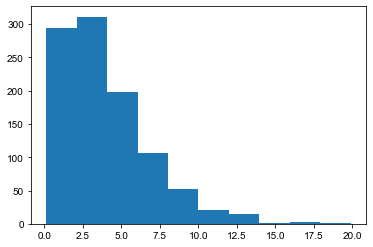

In [800]:
plt.hist(np.random.gamma(2, 2, 1000))

In [130]:
## BaselineNet 
def build_model():
    model = keras.Sequential([
        Dense(512, activation=tf.nn.relu, input_shape=[len(train_data[0])]),
        Dense(256, activation=tf.nn.relu, input_shape=[512]),
        Dense(48, activation=tf.nn.relu, input_shape=[256]),
        Dense(1)
    ])

    model.compile(optimizer=tf.optimizers.Adam(), 
                  loss='mse',
                  metrics=['mae', 'mse'])
    return model

In [210]:
# this helps makes our output less verbose but still shows progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(train_data, train_labs, epochs=5000, verbose=0, validation_split=0.1,
                    callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


....................................................................................................
.............................................................................

In [211]:
hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,2.346298,0.650514,2.346298,97.191254,7.712159,97.191254,0
1,0.164825,0.263422,0.164825,99.088425,7.988526,99.088425,1
2,0.113944,0.227463,0.113944,52.135036,5.541735,52.135036,2
3,0.102719,0.222813,0.102719,48.324078,5.732059,48.324078,3
4,0.114581,0.234678,0.114581,9.308419,2.343256,9.308419,4
...,...,...,...,...,...,...,...
172,0.064462,0.165004,0.064462,0.398427,0.468978,0.398427,172
173,0.064921,0.166090,0.064921,0.204309,0.331277,0.204309,173
174,0.065017,0.166226,0.065017,0.249758,0.376583,0.249758,174
175,0.064518,0.165227,0.064518,0.212304,0.349203,0.212304,175


In [101]:
rmse_final = np.sqrt(float(hist['val_mse'].tail(1)))
print()
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))


Final Root Mean Square Error on validation set: 7625.646


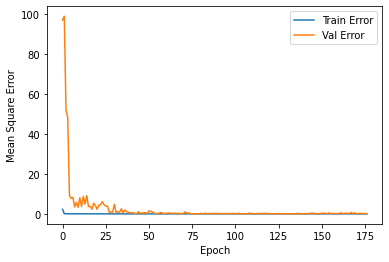

In [212]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()

plot_history()

In [ ]:
#test_features_norm = (test_data - train_mean) / train_std
mse, _, _ = model.evaluate(test_data, test_labs)
rmse = np.sqrt(mse)
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

7/7 [==============================] - 0s 2ms/step - loss: 19176.2168 - mae: 119.0167 - mse: 19176.2168
Root Mean Square Error on test set: 138.478


In [695]:
preds = np.exp(np.ravel(model.predict(test_data)))
#test_data.shape

Text(40000, 2500, 'Intercept=231.48')

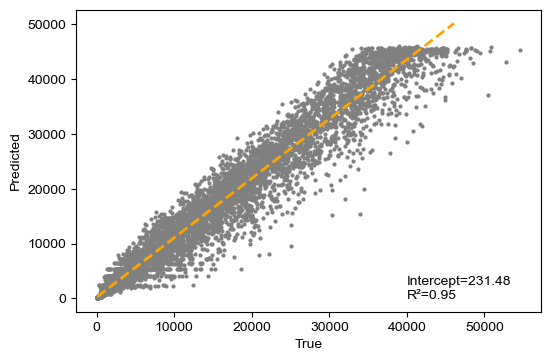

In [746]:
plt.figure(dpi=100)
plt.ylabel('Predicted')
plt.xlabel('True')
plt.plot(np.exp(np.ravel(test_labs)), preds, 'o', color='grey', markersize=2)
res = sm.OLS(preds, sm.add_constant(np.exp(np.ravel(test_labs)))).fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(preds), np.max(preds), 20)
plt.plot(x_, muhat + betahat * x_, color="orange", linestyle='--', linewidth=2)
plt.text(40000, 2, "R² = {:.2f}".format(res.rsquared))
plt.text(40000, 2500, "Intercept = {:.2f}".format(muhat))

In [732]:
x_=np.linspace(0,50000,20)

In [724]:
ax

[<AxesSubplot:xlabel='True', ylabel='Predicted'>]

In [699]:
res = sm.OLS(np.exp(np.ravel(test_labs)), sm.add_constant(preds)).fit()

In [702]:
res.rsquared

0.9543762545731239

## VAE ('similar' to architecture above)

Borrowed from https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/

In [798]:
intermediate_dim = 128
latent_dim = 16
batch_size = 512
epsilon_std = 1.0

def mse(y_true, y_pred):
    return keras.backend.sum(keras.metrics.mean_squared_error(y_true, y_pred), axis=-1)

class KLDivergenceLayer(Layer):
    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        kl_batch = - .5 * keras.backend.sum(1 + log_var -
                                            keras.backend.square(mu) -
                                            keras.backend.exp(log_var), axis=-1)

        self.add_loss(keras.backend.mean(kl_batch), inputs=inputs)
        return inputs

# input is 2 dim - (Xl, gamma)
x = keras.Input(shape=(2,))
h = Dense(48, activation='relu')(x)
h = Dense(intermediate_dim, activation='relu')(h)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: keras.backend.exp(.5*t))(z_log_var)

eps = keras.Input(tensor=keras.backend.random_normal(stddev=epsilon_std, shape=(keras.backend.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

# only need 1 output dim - allele age
decoder = keras.Sequential([
    Dense(48, input_dim=latent_dim, activation='relu'), 
    Dense(intermediate_dim, input_dim=48, activation='relu'), 
    Dense(1, activation='relu')
])

x_pred = decoder(z)
# symbolic representation
encoder = keras.Model(x, outputs=[z_mu, z_sigma])

In [801]:
vae = keras.Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=mse)

# vae.fit((train_data, train_data), train_labs,
#         shuffle=True,
#         epochs=50,
#         batch_size=batch_size,
#         validation_data=((test_data, test_data), test_labs))

history = vae.fit((train_data, np.random.randn(train_data.shape[0],latent_dim)), train_labs, epochs=5000, verbose=0, validation_split=0.1, shuffle=True,
                    validation_data=((test_data, np.random.randn(test_data.shape[0],latent_dim)), test_labs), 
                    callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch


.......................................................

(array([ 7., 15., 13., 17., 17., 12.,  9.,  3.,  5.,  2.]),
 array([5.13754988, 5.24608502, 5.35462017, 5.46315532, 5.57169046,
        5.68022561, 5.78876076, 5.8972959 , 6.00583105, 6.1143662 ,
        6.22290134]),
 <BarContainer object of 10 artists>)

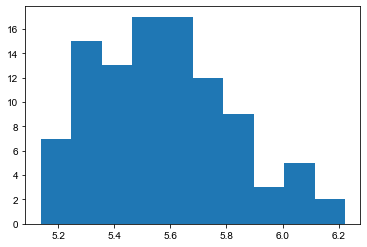

In [811]:
plt.hist(preds_vae[:,9])

(array([ 105.,  573., 2255., 2748.,  740.,  617.,  230.,  159.,   20.,
          53.]),
 array([-0.3626033 , -0.26006657, -0.15752982, -0.05499307,  0.04754367,
         0.15008041,  0.25261715,  0.3551539 ,  0.45769066,  0.5602274 ,
         0.66276413], dtype=float32),
 <BarContainer object of 10 artists>)

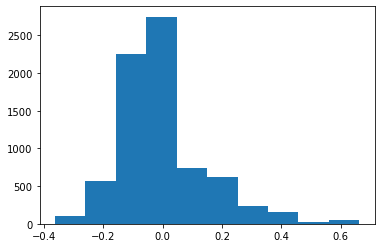

In [439]:
#np.vstack((np.random.normal(np.arange(3),np.repeat(0.01,3)),np.random.normal(np.arange(3),np.repeat(0.01,3)))).T.shape
#np.random.normal(z_preds[0][0:2,0], z_preds[1][0:2,0])

In [790]:
z_preds = encoder.predict(test_data)
preds_mean_vae = np.exp(np.ravel(decoder.predict(z_preds[0])))

In [791]:
nsamps = 100
z_samps = np.empty((test_labs.shape[0], latent_dim))
preds_vae = np.empty((nsamps, test_labs.shape[0]))
for i in range(nsamps):
    for l in range(latent_dim):
        z_samps[:,l] = np.random.normal(z_preds[0][:,l], z_preds[1][:,l])
    preds_vae[i,:] = decoder.predict(z_samps).reshape(-1)

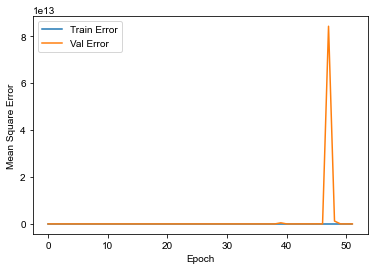

In [796]:
def plot_history():
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['loss'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.legend()

plot_history()

Text(40000, 2500, 'Intercept = 88.00')

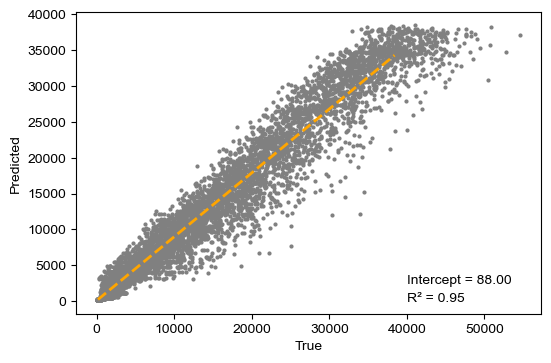

In [792]:
plt.figure(dpi=100)
plt.ylabel('Predicted')
plt.xlabel('True')
plt.plot(np.exp(np.ravel(test_labs)), preds_mean_vae, 'o', color='grey', markersize=2)
res = sm.OLS(preds_mean_vae, sm.add_constant(np.exp(np.ravel(test_labs)))).fit()
muhat, betahat = res.params
x_ = np.linspace(np.min(preds_mean_vae), np.max(preds_mean_vae), 20)
plt.plot(x_, muhat + betahat * x_, color="orange", linestyle='--', linewidth=2)
plt.text(40000, 2, "R² = {:.2f}".format(res.rsquared))
plt.text(40000, 2500, "Intercept = {:.2f}".format(muhat))

In [451]:
## REMINDER: taking mean of predictions and then exponentiating is *different* from exponentiating and taking mean (former is lower than latter)
plt.figure(dpi=100)
plt.xlabel('Exp(Mean(Pred))')
plt.ylabel('Mean(Exp(Pred))')
plt.plot(np.exp(np.mean(preds_vae,0)), np.mean(np.exp(preds_vae),0), 'o',  color="grey", markersize=2)

TypeError: axline() takes from 1 to 2 positional arguments but 4 were given

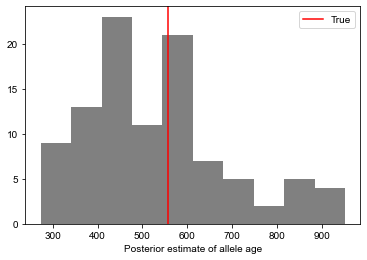

In [795]:
## plot histogram of samples of allele age...
plt.hist(np.exp(preds_vae[:,5]), color="grey")
plt.xlabel('Posterior estimate of allele age')
plt.axvline(x=np.exp(test_labs[5]), color="red", label="True")
plt.legend()

In [760]:
pa = decoder.predict_proba(z_preds[0])

0.0010000000000000002 -100.0


(array([4.000e+00, 1.500e+01, 0.000e+00, 0.000e+00, 1.100e+01, 7.454e+03,
        1.500e+01, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0.00013333, 0.00013333, 0.00013333, 0.00013333, 0.00013333,
        0.00013333, 0.00013333, 0.00013333, 0.00013333, 0.00013333,
        0.00013333], dtype=float32),
 <BarContainer object of 10 artists>)

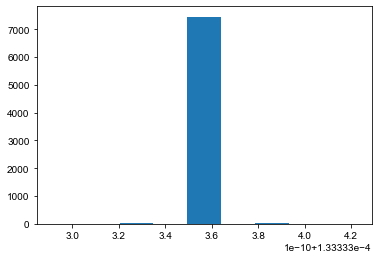

In [785]:
plt.hist(preds_mean_vae/np.sum(preds_mean_vae))

(array([2686., 1042.,  640.,  594.,  465.,  428.,  348.,  377.,  477.,
         443.]),
 array([  214.89246,  3691.0837 ,  7167.275  , 10643.466  , 14119.657  ,
        17595.848  , 21072.04   , 24548.23   , 28024.422  , 31500.613  ,
        34976.805  ], dtype=float32),
 <BarContainer object of 10 artists>)

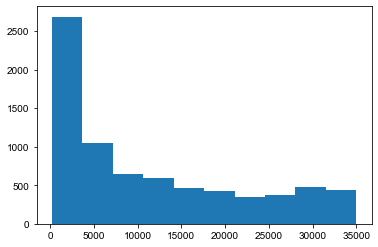

In [564]:
def get_eci(x, alpha=0.05):
    e_ecdf = ECDF(np.sort(x))
    return (e_ecdf.x[e_ecdf.y<=alpha][-1], e_ecdf.x[e_ecdf.y>=(1-alpha)][0])

In [689]:
# check if true values fall within 95% CI of the estimates
inctr = np.full(len(test_labs), False, dtype='bool')
for i in range(len(test_labs)):
    lb, ub = get_eci(np.exp(preds_vae[:,i]))
    if np.exp(test_labs[i])>=lb and np.exp(test_labs[i])<=ub:
        inctr[i] = True

print('Accuracy: {:.2f}%'.format(100*np.sum(inctr)/len(test_labs)))

Accuracy: 88.16%


Text(0, 0.5, 'gamma')

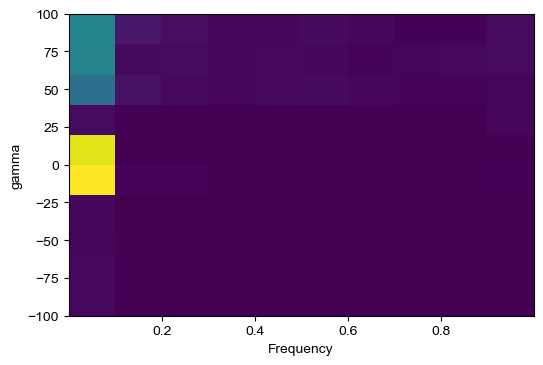

In [690]:
# frequencies & gamma at which prediction was not within the CI
plt.figure(dpi=100)
plt.hist2d(np.exp(test_data[np.ravel(np.where(~inctr)),0]), test_data[np.ravel(np.where(~inctr)),1])
plt.xlabel('Frequency')
plt.ylabel('gamma')

In [629]:
np.where(~inctr)

(array([  53,   54,  109,  138,  227,  229,  364,  504,  513,  834, 1019,
        1073, 1101, 1153, 1172, 1175, 1188, 1189, 1224, 1225, 1226, 1241,
        1257, 1261, 1270, 1277, 1314, 1368, 1389, 1398, 1404, 1426, 1448,
        1491, 1541, 1545, 1561, 1569, 1570, 1584, 1588, 1634, 1652, 1658,
        1661, 1676, 1677, 1683, 1692, 1696, 1705, 1720, 1727, 1735, 1736,
        1759, 1770, 1773, 1790, 1810, 1853, 1856, 1867, 1888, 1895, 1904,
        1949, 1952, 1957, 1984, 1988, 2021, 2044, 2048, 2051, 2064, 2065,
        2072, 2090, 2103, 2105, 2111, 2118, 2133, 2135, 2155, 2159, 2183,
        2185, 2189, 2193, 2201, 2208, 2214, 2218, 2238, 2242, 2251, 2272,
        2273, 2282, 2294, 2295, 2339, 2343, 2354, 2360, 2376, 2421, 2441,
        2447, 2475, 2483, 2495, 2497, 2504, 2509, 2523, 2534, 2560, 2564,
        2574, 2582, 2597, 2604, 2618, 2623, 2627, 2648, 2655, 2664, 2693,
        2706, 2712, 2735, 2755, 2769, 2770, 2775, 2781, 2784, 2798, 2808,
        2843, 2847, 2850, 2855, 2863, 

In [691]:
# get indices of observations which are under and over estimated - maybe something important to learn about them?
ab, be = [], []
for i in np.ravel(np.where(~inctr)):
    if(np.exp(test_labs[i]) < np.mean(np.exp(preds_vae[:,i]))):
        ab.append(i)
    else:
        be.append(i)

Text(0, 0.5, 'gamma')

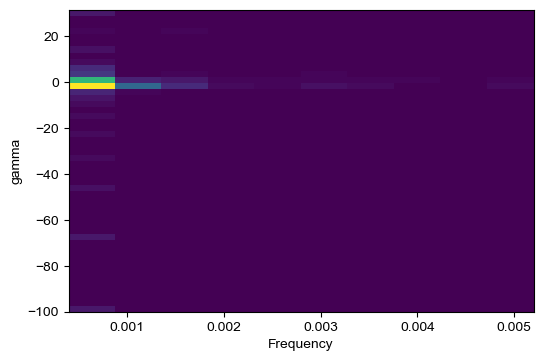

In [692]:
## OVERESTIMATED
plt.figure(dpi=100)
plt.hist2d(np.exp(test_data[ab,0]), test_data[ab,1], [10,50])
plt.xlabel('Frequency')
plt.ylabel('gamma')

Text(0, 0.5, 'gamma')

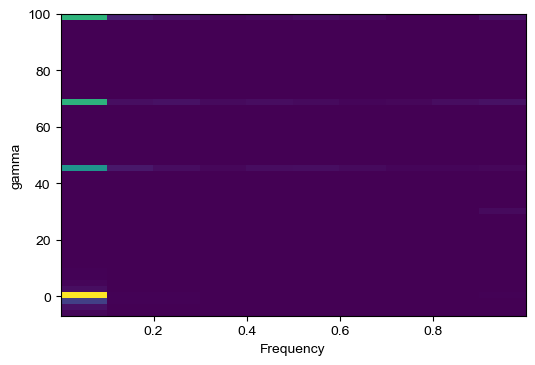

In [693]:
## UNDERESTIMATED
plt.figure(dpi=100)
plt.hist2d(np.exp(test_data[be,0]), test_data[be,1], [10,50])
plt.xlabel('Frequency')
plt.ylabel('gamma')

#### Prediction is worst when $|\gamma| < 0.02$ and $X_l < 5 \times 10^{-4}$ (basically neutral at that point...)

0.9844987910108202


Text(0.5, 1.0, 'Allele age estimation')

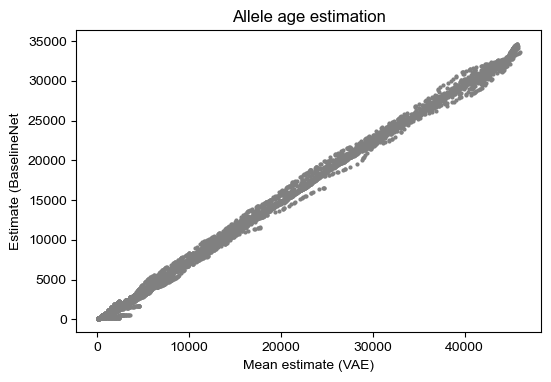

In [641]:
print(np.corrcoef(np.ravel(test_labs), np.ravel(preds))[0,1])
plt.figure(dpi=100)
plt.ylabel('Estimate (BaselineNet)')
plt.xlabel('Mean estimate (VAE)')
plt.plot(np.exp(np.ravel(preds)), np.exp(np.ravel(preds_mean_vae)), 'o',  color="grey", markersize=2)
plt.title('Allele age estimation')

In [46]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [43]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(2))
x = layers.Dense(16, activation="relu")(encoder_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 16)           48          input_9[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            34          dense_8[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            34          dense_8[0][0]                    
____________________________________________________________________________________________

In [17]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16, activation="relu")(latent_inputs)
decoder_outputs = layers.Dense(1, activation="relu")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


In [52]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, data, training=False):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data[0])
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(data[1], reconstruction)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [54]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

history = vae.fit(train_data, train_labs, epochs=1000, verbose=0, validation_split=0.1, batch_size=512,
                    callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

ValueError: in user code:

    /usr/local/anaconda3/envs/cvae/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    <ipython-input-52-e260ef82817f>:22 call  *
        z_mean, z_log_var, z = self.encoder(data[0])
    /usr/local/anaconda3/envs/cvae/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    /usr/local/anaconda3/envs/cvae/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:424 call
        return self._run_internal_graph(
    /usr/local/anaconda3/envs/cvae/lib/python3.9/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /usr/local/anaconda3/envs/cvae/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /usr/local/anaconda3/envs/cvae/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:234 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer dense_8 is incompatible with the layer: : expected min_ndim=2, found ndim=1. Full shape received: (2,)


In [18]:
(x_train, y_tr), (x_test, y_te) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


(60000,)

## Acknowledgements

The contents of this tutorial is based on and inspired by the work of [TensorFlow team](https://www.tensorflow.org) (see their [Colab notebooks](https://www.tensorflow.org/tutorials/)), our [MIT Human-Centered AI team](https://hcai.mit.edu), and individual pieces referenced in the [MIT Deep Learning](https://deeplearning.mit.edu) course slides.